# Walkthrough 8: Deep Dive into Data Analysis


Then fun doesn't stop when the Oqtant QMS hardware is offline! This walkthrough covers retrieving data from previously run and applying the ```output``` library to get the most out of your data.

### Imports and Authentication

In [ ]:
import matplotlib.pyplot as plt
from oqtant.schemas.quantum_matter import QuantumMatterFactory
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.optimize import curve_fit
from copy import deepcopy

qmf = QuantumMatterFactory()
qmf.get_login()

In [ ]:
qmf.get_client()

## Analysis Technique 0: Storing and organizing data 

When running jobs, you can save your data by using `QuantumMatter.write_to_file()`, which stores all input and output data in a '.txt' file. In this notebook, we will load `OqtantJob` data that is included in the Oqtant Documentation repository in the "data/" folder. This is a great way to analyze your data after the fact, or to share data with friends and colleagues so they can analyze data independently. If you have downloaded this notebook as a standalone file (not recommended), please be sure to download the sample job data and place it in the correct location for your filepath. 

The `refresh` argument in `qmf.load_matter_from_file` tells the client that the job contained in the file should be loaded as-is, and that the client should not query the database for a job with a matching id. This is important when you are loading a file which did not originate with your user account, as the client will not be able to locate a matching job id in the service. You can still access all the functionality of `output` and the `QuantumMatter` libraries when loading from a file in this way.

In [3]:
BEC_job_filepath = "data/example_BEC_job.txt"
BARRIER_job_filepath = "data/example_BARRIER_job.txt"

BEC_matter = qmf.load_matter_from_file(BEC_job_filepath, refresh=False)
BARRIER_matter = qmf.load_matter_from_file(BARRIER_job_filepath, refresh=False)

### Extract input parameters and outputs from loaded jobs

In [4]:
print(
    f"Example BEC RF_evaporation final frequency: {BEC_matter.input.rf_evaporation.frequencies_mhz[-1]} MHz"
)
print(f"Example BEC calculated temperature: {BEC_matter.output.temperature_nk:d} nK")

Example BEC RF_evaporation final frequency: 0.02 MHz
Example BEC calculated temperature: 122 nK


### Quick and easy plotting with ```output.py``` functions

We can directly plot the output data that is stored in the new quantum matter objects. These example jobs include a ```BEC``` job creating quantum matter, and a ```BARRIER``` job which captures dynamics in a BEC. See our [demos](https://oqtant-docs.infleqtion.com/examples/demos/demo_1_quantum_interference/) page for additional exciting examples of experiments you can run with Oqtant. 

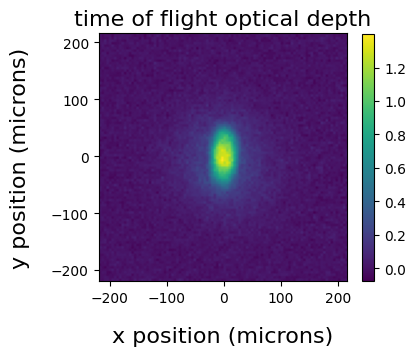

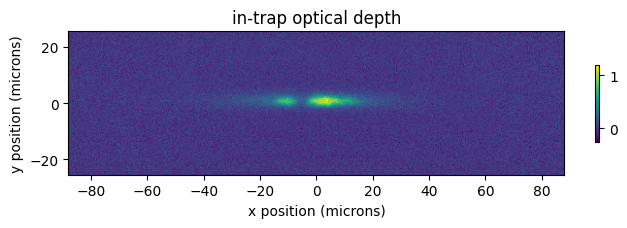

In [5]:
BEC_matter.output.plot_tof(figsize=(4, 4))
BARRIER_matter.output.plot_it(figsize=(8, 4))

### Operate on saved data to do custom analysis

Running your experiment is only half the fun - the magic is in the analysis! There are lots of ways to access and work with Oqtant data, some of which are demonstrated in the sections below. 

Note that the ```output``` library contains many other useful functions for analysis of Oqtant data: accessing pixel data, fitting, and image parameters.

## Analysis Technique 1: Averaging

When working with real quantum systems, mitigating the effects of noise is an important part of data analysis. A simple technique for improving the signal-to-noise ratio (SNR) of a measurement is averaging. If we assume that the sources of noise are uncorrelated to our signal of interest and random in distribution, then averaging over $N$ repetitions of a measurement gives a $\sqrt N$ improvement in the SNR. 

Oqtant QMS collects signals with a camera and a probe laser beam, both of which introduce sources of noise to the measurements of quantum dynamics. The atom cloud itself also fluctuates slightly between runs of the experiment as ultracold atoms are highly sensitive to some types of environmental fluctuations - natural quantum sensors! Learn more about imaging in Oqtant QMS in this [technical note](https://oqtant.infleqtion.com/technical/imaging.md). 

Load repeated trial data from files and average the results:

In [6]:
base_filename = "data/trial"
num_runs = 10

repeated_trial_matters = [
    qmf.load_matter_from_file(f"{base_filename}{i+1:d}.txt", refresh=False)
    for i in range(num_runs)
]

it_rows = repeated_trial_matters[0].output.it_plot.rows
it_columns = repeated_trial_matters[0].output.it_plot.columns
it_pixcal = repeated_trial_matters[0].output.get_image_pixcal(image="IN_TRAP")

avg_it_pixels = np.zeros((it_rows, it_columns))
avg_slice = np.zeros(it_columns)

for trial in repeated_trial_matters:
    avg_it_pixels += trial.output.get_image_data(image="IN_TRAP")
    avg_slice += trial.output.get_image_data(image="IN_TRAP")[int(it_rows / 2)]

avg_it_pixels /= num_runs
avg_slice /= num_runs

x_positions = np.arange(
    -it_columns / 2 * it_pixcal, it_columns / 2 * it_pixcal, it_pixcal
)
y_positions = np.arange(-it_rows / 2 * it_pixcal, it_rows / 2 * it_pixcal, it_pixcal)

### Custom plotting of processed data

Create custom plots of your processed job results for your research. Here we present the averaged result and the averaged profile along the same X axis for easy viewing, plus a custom colorbar. Cute!

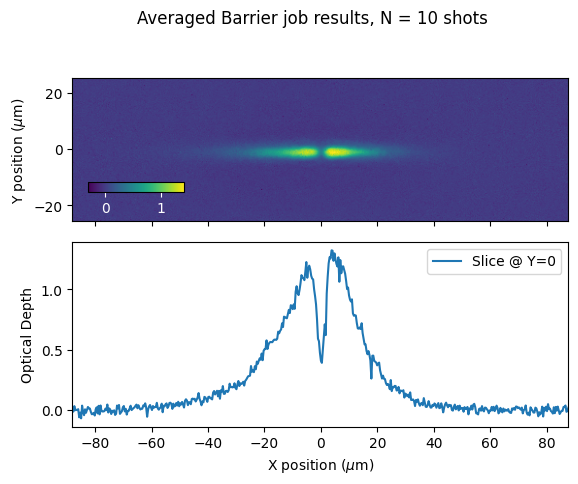

In [7]:
fig, axs = plt.subplots(nrows=2, sharex=True)
fig.suptitle("Averaged Barrier job results, N = 10 shots")
im = axs[0].imshow(
    avg_it_pixels,
    extent=[x_positions[0], x_positions[-1], y_positions[0], y_positions[-1]],
)
cbaxes = fig.add_axes([0.15, 0.6, 0.15, 0.02])
cb = plt.colorbar(im, cax=cbaxes, ticks=[0.0, 1], orientation="horizontal")
cbaxes.tick_params(color="w", labelcolor="w")

axs[1].plot(x_positions, avg_slice, label="Slice @ Y=0")
axs[1].set_ylabel("Optical Depth")
axs[1].set_yticks([0, 0.5, 1])
axs[1].set_xlabel("X position ($\mu$m)")
axs[1].legend()
axs[0].set_ylabel("Y position ($\mu$m)")
plt.subplots_adjust(hspace=0)
plt.show()

## Analysis Technique 2: Fitting Data and Correcting for Acquisition Errors

Nearly all aspects of data analysis use some form of curve fitting - this section illustrates how to execute 1D curve-fitting of an interference pattern on a cloud of quantum matter. In addition, a little clean-up of the data is needed to get the best fitting results, so we also demonstrate examples of how one might process their data for best fitting results. Note that this is just one example of how to analyze data - you should experiment with different fit functions and different ways of analyzing your data based on the specifics of your jobs!

### Load interference example data from files

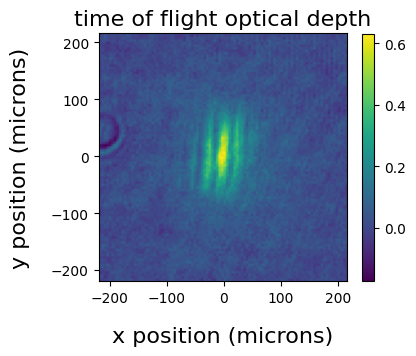

In [8]:
filename = "data/interference_tof.txt"
tof_matter = qmf.load_matter_from_file(
    filename, refresh=False
)

tof_matter.output.plot_tof(figsize = (4, 4))

### Data processing

In the time-of-flight data above, we can see nice interference fringes on the cloud of quantum matter. Our goal is now to fit the cloud to a function in order to measure the wavelength and amplitude of the interference pattern. 

We can see some unwanted effects in the image as well: a spec of dust shows up on the right side of the image, there are some other imaging fringes in the background, and lastly the main fringe pattern on the cloud is very slightly rotated from vertical. We will address this in our data analysis by 1) rotating the image so that the fringes are vertical, 2) cropping the image to remove unnecessary background data around the cloud, and 3) summing the cloud vertically so we can reduce the signal to noise ratio and analyze the fringes in 1D. Note: another way to smooth data is to apply a Gaussian filter - we leave this exercise to the interested reader!

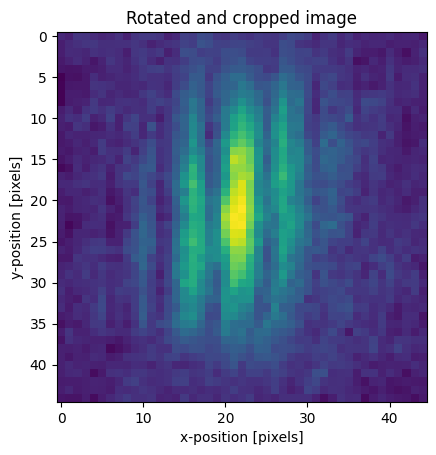

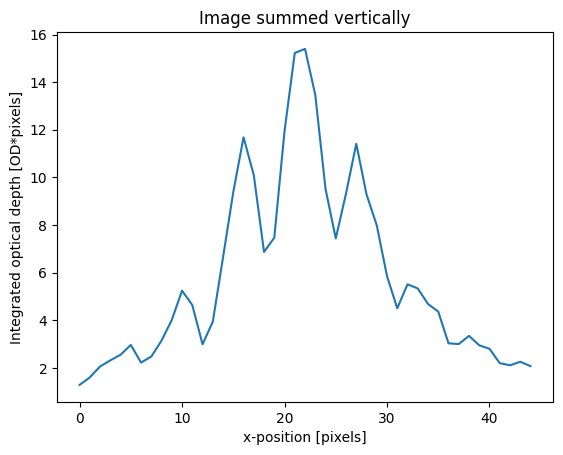

In [9]:
theta = 3 # degrees
crop = 30 # number of pixels to crop from each side

im_original = tof_matter.output.get_image_data(image="TIME_OF_FLIGHT")

im_new = rotate(im_original, theta)
im_new = im_new[crop:-crop, crop:-crop]
im_sum = np.sum(im_new, axis=0) # sum vertically to project onto the x-axis

plt.figure()
plt.title("Rotated and cropped image")
plt.imshow(im_new)
plt.xlabel("x-position [pixels]")
plt.ylabel("y-position [pixels]")
plt.figure()
plt.title("Image summed vertically")
plt.plot(im_sum)
plt.xlabel("x-position [pixels]")
plt.ylabel("Integrated optical depth [OD*pixels]")
plt.show()

### Fit data to sinusoidally modulated Gaussian

In order to fit our data to a curve, we have to have a guess for what functional form might best fit the data. In this case, the quantum matter cloud is roughly shaped like a Gaussian that has a sinusoidal modulation of the amplitude. We define that below, and demonstrate how to use `scipy.optimize.curve_fit()` for fitting the data.

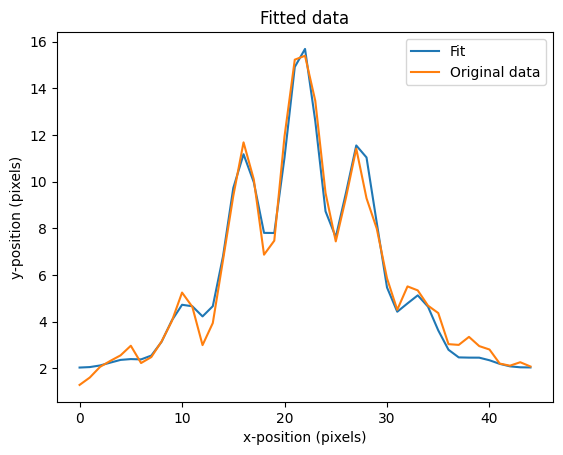

In [10]:
def modulated_gaussian(x, a_g, os, x0_g, sig_g, a_s, lambda_s, phi_s):
    """Function for a sinusoidally modulated 1D Gaussian
    
    Inputs:
    x: x-position at which to evaluate the function value (pixels)
    a_g: Overall Gaussian amplitude
    os: Vertical offset of the plot
    x0_g: initial x-location of the center of the Gaussian (pixels)
    sig_g: Gaussian sigma (pixels)
    a_s: Fractional sine-wave amplitude, from 0 to 1
    lambda_s: spatial wavelength of modulation
    phi_s: Initial phase of the sine wave, relative to the gaussian center
    """
    k_s = 2*np.pi / lambda_s # Turn the spacial wavelength into a k-vector
    return a_g * (1 + a_s*np.cos(k_s*(x-x0_g) + phi_s)) * np.exp(-(x-x0_g)**2 / (2*sig_g**2)) + os

# Initial guess of parameter values p0, lower bounds lb, and upper bounds ub
# There are in the order of the modulated Gaussian inputs above, starting from 
# the a_g input. 
p0 = [10, 1, 22, 8, 0.3, 8, 0]
lb = [7, 0, 18, 5, 0.1, 4, -np.pi]
ub = [14, 2, 26, 12, 0.5, 12, np.pi]

# Make an array that serves at the x-axis of the data
x_pts = np.arange(len(im_sum))

# Fit with scipy.optimize.curve_fit
fits, errors = curve_fit(modulated_gaussian, x_pts, im_sum, p0=p0, bounds=(lb, ub))

ys = modulated_gaussian(x_pts, *fits)

plt.figure()
plt.title("Fitted data")
plt.plot(x_pts, ys, label="Fit")
plt.plot(x_pts, im_sum, label="Original data")
plt.xlabel("x-position (pixels)")
plt.ylabel("y-position (pixels)")
plt.legend()
plt.show()

### Finding the optimal rotation angle of the data

Above, you may have noticed that we picked a rotation angle (3 degrees) without any justification for it! Let's see if we can show that this is indeed the optimal rotation angle to align the fringe pattern vertically. We will use the fact that when the fringe pattern is aligned vertically, we will see the maximum fitted amplitude of the sine modulation. This is because when the angle is incorrect but the data is summed vertically, it averages over neighboring fringes and begins to wash out the modulated signal. Below, we can see that the fitted modulation amplitude is indeed the highest around 3 degree rotation angle.

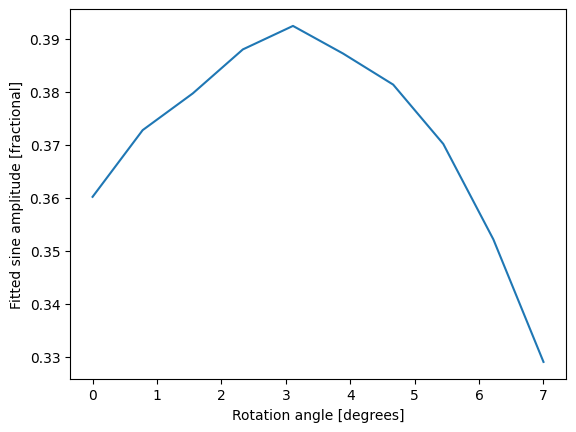

In [11]:
thetas = np.linspace(0, 7, 10) #array of angles to rotate by (degrees)
amplitudes = [] # empty list to store fitted amplitudes at each angle theta

for theta in thetas:
    # Rotate, crop and sum the data
    im = rotate(im_original, theta)
    im = im[crop:-crop, crop:-crop]
    im_sum = np.sum(im, axis=0)
    
    # set up initial guess, and upper/lower bounds
    p0 = [10, 1, 22, 8, 0.3, 8, 0]
    lb = [7, 0, 18, 5, 0.1, 4, -np.pi]
    ub = [14, 2, 26, 12, 0.5, 12, np.pi]

    x_pts = np.arange(len(im_sum))

    # fit curve
    fits, errors = curve_fit(modulated_gaussian, x_pts, im_sum, p0=p0, bounds=(lb, ub))

    amplitudes.append(fits[4]) # Extract the sine wave amplitude, which is the 5th element in the fit parameters

# Plot fitted sine wave amplitude versus rotation angle
plt.figure()
plt.xlabel("Rotation angle [degrees]")
plt.ylabel("Fitted sine amplitude [fractional]")
plt.plot(thetas, amplitudes)
plt.show()

## Conclusions

In this notebook, we have looked at how to load old data from .txt files, and some tips/tricks for how to work with and analyze the data. Feel free to use any of this code in your notebooks as you're learning how to analyze Oqtant QMS data. And remember that it's always nice to save your job data as you run jobs in case you ever want to re-analyze the data sometime in the future! 